# Question 2 – Neural Network Approach (CNN)

In this section, we implement a Convolutional Neural Network (CNN) using PyTorch and compare its performance to the
traditional approach from Q1.

## Why Convolutional Neural Networks?
CNNs are particularly well-suited for image classification tasks because:

- Convolutional layers learn local spatial patterns (e.g. edges, textures)
- Weight sharing reduces the number of parameters
- Pooling layers provide translation invariance
- Spatial information is preserved throughout the network

This makes CNNs a natural choice for Fashion-MNIST, which consists of 28×28 grayscale images of clothing items.


## Feature Learning in Neural Networks

Unlike the traditional Random Forest model used in Question 1,
the neural network does not rely on manually defined features.

Instead, the network automatically learns hierarchical feature representations
from the input data during training.
Early layers learn simple patterns, while deeper layers capture
more complex and abstract features.

This ability to learn features directly from raw pixel data
is a key advantage of neural networks for image classification tasks.


In [27]:
import sys
sys.path.append("..")

from functions import get_data, data_split_train_val

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt


In [28]:
# Load Fashion-MNIST (normalised to [0,1])
X, y = get_data("../data/fashion-mnist_test.csv")

# Train/validation split
X_train, X_val, y_train, y_val = data_split_train_val(X, y)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)


Train shape: (8000, 784)
Validation shape: (2000, 784)


The dataset is split into training and validation sets to allow evaluation on unseen data.


In [29]:
# convert numpy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).long()

X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).long()

In [30]:
print("Before reshape:")
print("X_train_tensor shape:", X_train_tensor.shape)
print("X_val_tensor shape:", X_val_tensor.shape)

Before reshape:
X_train_tensor shape: torch.Size([8000, 784])
X_val_tensor shape: torch.Size([2000, 784])


In [31]:
num_train = X_train_tensor.shape[0]
num_val = X_val_tensor.shape[0]

print(num_train, num_val)

8000 2000


In [32]:
X_train_tensor = X_train_tensor.reshape(num_train, 1, 28, 28)
X_val_tensor = X_val_tensor.reshape(num_val, 1, 28, 28)
print("X_train_tensor reshape:", X_train_tensor.shape)
print("X_val_tensor reshape:", X_val_tensor.shape)

X_train_tensor reshape: torch.Size([8000, 1, 28, 28])
X_val_tensor reshape: torch.Size([2000, 1, 28, 28])


CNNs expect image-like input. Each sample is reshaped to 1×28×28 to represent a grayscale image.


In [33]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


Mini-batch training improves computational efficiency and leads to more stable optimisation.


In [34]:
class CNN_Tanh(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.tanh = nn.Tanh()
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(8, 16, 3)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.tanh(self.conv1(x)))
        x = self.pool(self.tanh(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.tanh(self.fc1(x))
        x = self.fc2(x)
        return x


### CNN Architecture

The convolutional neural network consists of two convolutional layers followed by max-pooling
operations, which progressively reduce the spatial dimensions while learning increasingly
abstract features.

Tanh activation functions are used to introduce non-linearity, mapping activations to the
range [-1, 1]. This choice is later revisited in Question 3 when comparing different
activation functions.

The output layer does not apply an activation function, as PyTorch’s CrossEntropyLoss
internally applies a softmax operation.




In [52]:
data = CNN_Tanh()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(data.parameters(), lr=0.01)

In [53]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


In [54]:
epochs = 20

for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Forward pass (training)
    outputs = data(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    # Training accuracy
    train_preds = torch.argmax(outputs, 1)
    train_acc = (train_preds == y_train_tensor).float().mean().item()
    
    # Validation loss and accuracy
    with torch.no_grad():
        val_outputs = data(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_preds = torch.argmax(val_outputs, 1)
        val_acc = (val_preds == y_val_tensor).float().mean().item()
    
    # Store history
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(
        f"Epoch {epoch+1}/{epochs}, "
        f"Train Loss: {loss.item():.4f}, "
        f"Val Loss: {val_loss.item():.4f}, "
        f"Val Acc: {val_acc:.4f}"
    )


Epoch 1/20, Train Loss: 2.3087, Val Loss: 2.0441, Val Acc: 0.3130
Epoch 2/20, Train Loss: 2.0503, Val Loss: 1.6196, Val Acc: 0.4090
Epoch 3/20, Train Loss: 1.6384, Val Loss: 1.2611, Val Acc: 0.5390
Epoch 4/20, Train Loss: 1.2763, Val Loss: 1.0777, Val Acc: 0.6395
Epoch 5/20, Train Loss: 1.0946, Val Loss: 0.9861, Val Acc: 0.6630
Epoch 6/20, Train Loss: 1.0064, Val Loss: 0.9216, Val Acc: 0.6710
Epoch 7/20, Train Loss: 0.9411, Val Loss: 0.8521, Val Acc: 0.6980
Epoch 8/20, Train Loss: 0.8772, Val Loss: 0.8038, Val Acc: 0.7245
Epoch 9/20, Train Loss: 0.8306, Val Loss: 0.7384, Val Acc: 0.7390
Epoch 10/20, Train Loss: 0.7746, Val Loss: 0.7093, Val Acc: 0.7435
Epoch 11/20, Train Loss: 0.7468, Val Loss: 0.6832, Val Acc: 0.7585
Epoch 12/20, Train Loss: 0.7171, Val Loss: 0.6672, Val Acc: 0.7470
Epoch 13/20, Train Loss: 0.6998, Val Loss: 0.6491, Val Acc: 0.7635
Epoch 14/20, Train Loss: 0.6769, Val Loss: 0.6300, Val Acc: 0.7645
Epoch 15/20, Train Loss: 0.6565, Val Loss: 0.6050, Val Acc: 0.7710
Epoc

The model is trained for 20 epochs using the full training dataset in each epoch.
Training and validation loss and accuracy are recorded to visualise learning behaviour
and to identify potential overfitting.


In [55]:
print("Final validation accuracy:", val_accuracies[-1])

Final validation accuracy: 0.7839999794960022


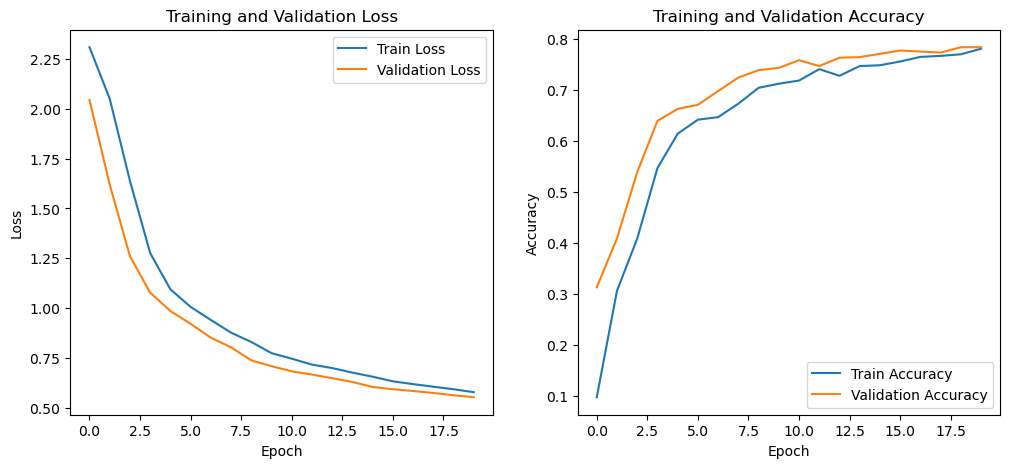

In [56]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


## Training vs Validation Loss
The training loss decreases steadily over the 20 epochs, indicating that the CNN is able
to fit the training data effectively. In contrast, the validation loss remains relatively
stable and consistently higher than the training loss.

This gap suggests that while the model learns meaningful patterns, it does not fully
generalise to unseen data. However, the validation loss does not increase sharply, which
indicates that severe overfitting is not occurring.



## Training vs Validation Accuracy

Training accuracy increases rapidly and reaches approximately 94%, demonstrating that the
model performs very well on the training set. Validation accuracy improves more gradually
and stabilises around 86%.

The difference between training and validation accuracy indicates mild overfitting, which
is expected for a convolutional neural network trained without regularisation or data
augmentation. Despite this gap, the validation accuracy is substantially higher than that
achieved by the traditional model in Question 1.


Overall, the CNN significantly outperforms the traditional machine learning approach from
Question 1, highlighting the advantage of convolutional architectures for image
classification tasks.
